In [1]:
import sys
from os.path import join, abspath, pardir
from glob import glob
import numpy as np
import pandas as pd
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from time import time
from multiprocessing import Pool
import emcee
import corner
from scipy.stats import norm, uniform

In [2]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/5_Anal',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [6]:
from utils import safe_mkdir, style, hdi, load_spectral_types, calculate_probs

In [7]:
sp = load_spectral_types(join(root_dir, "Data"))
sp

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [8]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [9]:
style(name="seaborn-notebook")

In [10]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [11]:
data_baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

In [12]:
eff_vol = glob(join(root_data_dir, 'Effective-Volume-v', "*"))
eff_vol.sort()
eff_vol

['/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.34)_(0.36).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-v/gaia_(0.36)_(0.38

In [13]:
import re
c1, c2 = [], []
# get the value between () of the file name
for f in eff_vol:
    c1.append(float(re.findall(r'\((.*?)\)', f)[0]))
    c2.append(float(re.findall(r'\((.*?)\)', f)[1]))
c1 = np.array(c1)
c2 = np.array(c2)
c = 0.5*(c1+c2)
c

array([-0.03 ,  0.07 ,  0.12 ,  0.16 ,  0.195,  0.225,  0.255,  0.28 ,
        0.305,  0.33 ,  0.35 ,  0.37 ,  0.39 ])

In [14]:
mcmc_dm_dir = join(root_data_dir, "MCMC", "dm", "data")

In [15]:
dm_2_files = glob(join(mcmc_dm_dir, "chain-2-*"))
dm_2_files.sort()
dm_2_files

['/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-1.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-10.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-11.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-12.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-2.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-3.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-5.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-6.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-7.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-8.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC/dm/data/chain-2-9.npy']

## tes

In [16]:
index = 2
df_dm = np.load(join(mcmc_dm_dir, f"chain-2-{index}.npy"))
df_dm.shape

(10000, 68, 33)

In [17]:
from scipy.stats import norm

rhob = df_dm[:, :, :12]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
rhoDM = df_dm[:, :, 24].reshape(-1)/1E-2
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

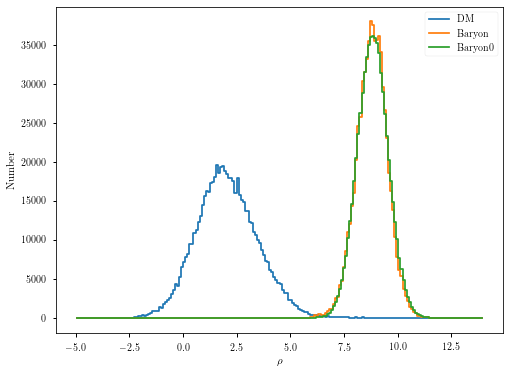

In [18]:
rho = np.linspace(-5, 14, 200)
rhoDM_num, _ = np.histogram(rhoDM, bins=rho)
rhob_num, _ = np.histogram(rhob, bins=rho)
rhob0_num, _ = np.histogram(rhob0, bins=rho)
rhomid = 0.5*(rho[1:] + rho[:-1])
# plot step
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(rhomid, rhoDM_num, label='DM')
ax.step(rhomid, rhob_num, label='Baryon')
ax.step(rhomid, rhob0_num, label='Baryon0')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Number')
ax.legend()
plt.show()

In [19]:
# fit with skew normal
from scipy.stats import skewnorm
rhoDM_fit = skewnorm.fit(rhoDM)
rhob_fit = skewnorm.fit(rhob)
rhob0_fit = skewnorm.fit(rhob0)

((1.3527218160867096, 0.9311969648376253, 1.8417199710612584),
 (-1.0277855839318701, 9.347444378219498, 0.8640572209452597),
 (0.00015771799520193592, 8.890435271894177, 0.7126525477141513))

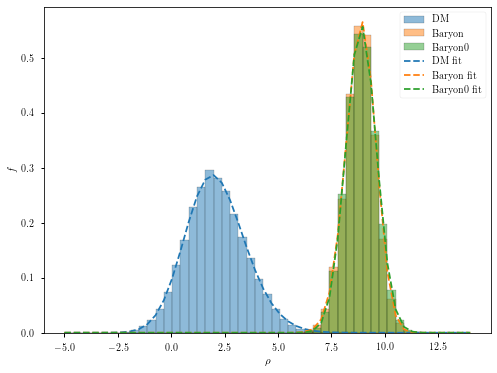

In [20]:
# plot
rho = np.linspace(-5, 14, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
rhoDM_fit, rhob_fit, rhob0_fit

In [21]:
from scipy.optimize import fmin
from scipy.integrate import quad

def find_max(func, x0=None):
  r""" Find maximum of a function
  """
  x0 = np.random.rand() if x0 is None else x0
  xMax = fmin(lambda x: -func(x), x0, disp=False)
  return xMax

def hdi(func, perc=0.68, res=1E3, min=0.0, max=1.0):
  r""" Highest density interval of {perc}% of normalized distribution
  perc: percentile
  res: resolution, number of sampling from distributiion
  min: min x-value
  max: max x-value
  """
  x = np.linspace(min, max, int(res))
  y = func(x)
  upper = np.max(y)*0.99
  below = 0
  for k in range(10):
    ys = np.linspace(upper, below, 10)
    for i in range(10):
      mask = y > ys[i]
      x_mask = x[mask]
      integral, _ = quad(func, a=x_mask[0], b=x_mask[-1])
      if(integral > perc): break
    upper = ys[i-1]
    below = ys[i]
    xMin = x_mask[0]
    xMax = x_mask[-1]
  return (xMin, xMax)

rhoDM = 1.92 +1.46/-1.31
rhob = 8.91 +0.68/-0.73
rhob0 = 8.89 +0.72/-0.71


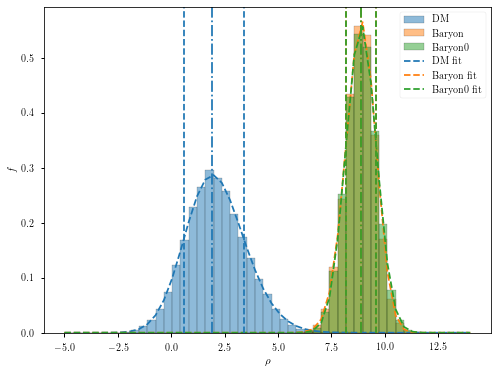

In [22]:
rhoDM_low, rhoDM_high = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_fit), x0=0.0)[0]

rhob_low, rhob_high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]

rhob0_low, rhob0_high = hdi(lambda x: skewnorm.pdf(x, *rhob0_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob0_mode = find_max(lambda x: skewnorm.pdf(x, *rhob0_fit), x0=0.0)[0]

# plot
rho = np.linspace(-5, 14, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoDM, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoDM_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhoDM_mode, color='C0', ls='-.')
ax.axvline(rhob_mode, color='C1', ls='-.')
ax.axvline(rhob0_mode, color='C2', ls='-.')
ax.axvline(rhoDM_low, color='C0', ls='--')
ax.axvline(rhoDM_high, color='C0', ls='--')
ax.axvline(rhob_low, color='C1', ls='--')
ax.axvline(rhob_high, color='C1', ls='--')
ax.axvline(rhob0_low, color='C2', ls='--')
ax.axvline(rhob0_high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhoDM = {rhoDM_mode:.02f} +{rhoDM_high-rhoDM_mode:.02f}/-{rhoDM_mode-rhoDM_low:.02f}')
print(f'rhob = {rhob_mode:.02f} +{rhob_high-rhob_mode:.02f}/-{rhob_mode-rhob_low:.02f}')
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low:.02f}')

In [23]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# find 68, 90, 95% HDI
rhob0_low68, rhob0_high68 = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob0_low90, rhob0_high90 = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.90, res=1E3, min=-5, max=14)
rhob0_low95, rhob0_high95 = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.95, res=1E3, min=-5, max=14)
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]

In [24]:
from tqdm import tqdm

rhoDM_v = []
rhoDM_fit = []
rhob_v = []
rhob_fit = []

for index in tqdm(range(13)):
    df_dm = np.load(join(mcmc_dm_dir, f"chain-2-{index}.npy"))
    rhob = df_dm[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df_dm[:, :, 24].reshape(-1)/1E-2
    print("fitting...")
    rhoDM_f = skewnorm.fit(rhoDM)
    rhob_f = skewnorm.fit(rhob)
    rhoDM_fit.append(rhoDM_f)
    rhob_fit.append(rhob_f)

    print("calculating HDI...")
    rhoDM_low68, rhoDM_high68 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_f), perc=0.68, res=1E3, min=-5, max=14)
    rhoDM_low90, rhoDM_high90 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_f), perc=0.90, res=1E3, min=-5, max=14)
    rhoDM_low95, rhoDM_high95 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_f), perc=0.95, res=1E3, min=-5, max=14)
    rhoDM_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_f), x0=0.0)[0]
    rhoDM_v.append([rhoDM_mode, rhoDM_low68, rhoDM_high68, rhoDM_low90, rhoDM_high90, rhoDM_low95, rhoDM_high95])

    rhob_low68, rhob_high68 = hdi(lambda x: skewnorm.pdf(x, *rhob_f), perc=0.68, res=1E3, min=-5, max=14)
    rhob_low90, rhob_high90 = hdi(lambda x: skewnorm.pdf(x, *rhob_f), perc=0.90, res=1E3, min=-5, max=14)
    rhob_low95, rhob_high95 = hdi(lambda x: skewnorm.pdf(x, *rhob_f), perc=0.95, res=1E3, min=-5, max=14)
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_f), x0=0.0)[0]
    rhob_v.append([rhob_mode, rhob_low68, rhob_high68, rhob_low90, rhob_high90, rhob_low95, rhob_high95])

  0%|          | 0/13 [00:00<?, ?it/s]

fitting...
calculating HDI...


  8%|▊         | 1/13 [00:17<03:32, 17.71s/it]

fitting...
calculating HDI...


 15%|█▌        | 2/13 [00:40<03:49, 20.83s/it]

fitting...
calculating HDI...


 23%|██▎       | 3/13 [01:10<04:08, 24.83s/it]

fitting...
calculating HDI...


 31%|███       | 4/13 [01:26<03:12, 21.37s/it]

fitting...
calculating HDI...


 38%|███▊      | 5/13 [02:03<03:36, 27.05s/it]

fitting...
calculating HDI...


 46%|████▌     | 6/13 [02:55<04:09, 35.60s/it]

fitting...
calculating HDI...


 54%|█████▍    | 7/13 [03:35<03:42, 37.05s/it]

fitting...
calculating HDI...


 62%|██████▏   | 8/13 [04:05<02:54, 34.82s/it]

fitting...
calculating HDI...


 69%|██████▉   | 9/13 [04:50<02:31, 37.79s/it]

fitting...
calculating HDI...


 77%|███████▋  | 10/13 [05:35<02:00, 40.05s/it]

fitting...
calculating HDI...


 85%|████████▍ | 11/13 [05:50<01:05, 32.55s/it]

fitting...
calculating HDI...


 92%|█████████▏| 12/13 [06:06<00:27, 27.56s/it]

fitting...
calculating HDI...


100%|██████████| 13/13 [06:32<00:00, 30.16s/it]


In [25]:
rhoDM_fit[0]

(1.4783812487953338, -0.14889610499929407, 1.884128570976315)

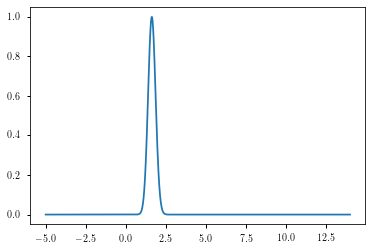

In [26]:
# multiplying the rhoDM, but it became addition in log
rho = np.linspace(-5, 14, 10000)
log_rhoDM = None
for p in rhoDM_fit:
    if log_rhoDM is None:
        log_rhoDM = skewnorm.logpdf(rho, *p)
    else:
        log_rhoDM += skewnorm.logpdf(rho, *p)
# turn into rhoDM
rhoDM_val = np.exp(log_rhoDM)
# find max value
rho_max = np.max(rhoDM_val)
# normalize
rhoDM_val /= rho_max
# plot
fig, ax = plt.subplots()
ax.plot(rho, rhoDM_val, label='rhoDM')

In [27]:
from scipy.optimize import curve_fit

rhoDM_com_fit, _ = curve_fit(skewnorm.pdf, rho, rhoDM_val, p0=[0.0, 1.0, 1.0])

In [28]:
# find mode, 68, 90, 95% HDI for rhoDM_com
rhoDM_com_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), x0=0.0)[0]
rhoDM_com_low68, rhoDM_com_high68 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoDM_com_low90, rhoDM_com_high90 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), perc=0.90, res=1E3, min=-5, max=14)
rhoDM_com_low95, rhoDM_com_high95 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), perc=0.95, res=1E3, min=-5, max=14)
print(f'rhoDM_com = {rhoDM_com_mode:.02f} +{rhoDM_com_high68-rhoDM_com_mode:.02f}/-{rhoDM_com_mode-rhoDM_com_low68:.02f}')
print(f'rhoDM_com = {rhoDM_com_mode:.02f} +{rhoDM_com_high90-rhoDM_com_mode:.02f}/-{rhoDM_com_mode-rhoDM_com_low90:.02f}')
print(f'rhoDM_com = {rhoDM_com_mode:.02f} +{rhoDM_com_high95-rhoDM_com_mode:.02f}/-{rhoDM_com_mode-rhoDM_com_low95:.02f}')
print(f"{rhoDM_com_mode:.02f} & [{rhoDM_com_low68:.02f},{rhoDM_com_high68:.02f}] & [{rhoDM_com_low90:.02f},{rhoDM_com_high90:.02f}] & [{rhoDM_com_low95:.02f},{rhoDM_com_high95:.02f}] \\\\")

rhoDM_com = 1.60 +0.42/-0.34
rhoDM_com = 1.60 +0.72/-0.53
rhoDM_com = 1.60 +0.87/-0.63
1.60 & [1.26,2.02] & [1.07,2.32] & [0.97,2.47] \\


# \\/ Skip

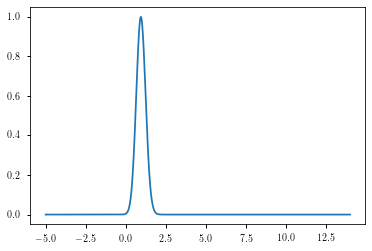

In [72]:
# tanpa F
# multiplying the rhoDM, but it became addition in log
rho = np.linspace(-5, 14, 10000)
log_rhoDM = None
for i, p in enumerate(rhoDM_fit):
    if i in [3, 4, 5, 6, 7, 8]:
        continue
    if log_rhoDM is None:
        log_rhoDM = skewnorm.logpdf(rho, *p)
    else:
        log_rhoDM += skewnorm.logpdf(rho, *p)
# turn into rhoDM
rhoDM_val = np.exp(log_rhoDM)
# find max value
rho_max = np.max(rhoDM_val)
# normalize
rhoDM_val /= rho_max
# plot
fig, ax = plt.subplots()
ax.plot(rho, rhoDM_val, label='rhoDM')

In [73]:
from scipy.optimize import curve_fit

rhoDM_com_fit, _ = curve_fit(skewnorm.pdf, rho, rhoDM_val, p0=[0.0, 1.0, 1.0])

In [74]:
# find mode, 68, 90, 95% HDI for rhoDM_com
rhoDM_com_mode = find_max(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), x0=0.0)[0]
rhoDM_com_low68, rhoDM_com_high68 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoDM_com_low90, rhoDM_com_high90 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), perc=0.90, res=1E3, min=-5, max=14)
rhoDM_com_low95, rhoDM_com_high95 = hdi(lambda x: skewnorm.pdf(x, *rhoDM_com_fit), perc=0.95, res=1E3, min=-5, max=14)
print(f'rhoDM_com = {rhoDM_com_mode:.02f} +{rhoDM_com_high68-rhoDM_com_mode:.02f}/-{rhoDM_com_mode-rhoDM_com_low68:.02f}')
print(f'rhoDM_com = {rhoDM_com_mode:.02f} +{rhoDM_com_high90-rhoDM_com_mode:.02f}/-{rhoDM_com_mode-rhoDM_com_low90:.02f}')
print(f'rhoDM_com = {rhoDM_com_mode:.02f} +{rhoDM_com_high95-rhoDM_com_mode:.02f}/-{rhoDM_com_mode-rhoDM_com_low95:.02f}')
print(f"{rhoDM_com_mode:.02f} & [{rhoDM_com_low68:.02f},{rhoDM_com_high68:.02f}] & [{rhoDM_com_low90:.02f},{rhoDM_com_high90:.02f}] & [{rhoDM_com_low95:.02f},{rhoDM_com_high95:.02f}] \\\\")

rhoDM_com = 0.93 +0.38/-0.36
rhoDM_com = 0.93 +0.67/-0.57
rhoDM_com = 0.93 +0.80/-0.68
0.93 & [0.57,1.31] & [0.36,1.60] & [0.25,1.73] \\


# ^skip

In [29]:
A9 = sp[sp['SpT'] == 'A9V']['J-K'].values[0]
F0 = sp[sp['SpT'] == 'F0V']['J-K'].values[0]
b1 = (A9+F0)/2

F9 = sp[sp['SpT'] == 'F9V']['J-K'].values[0]
G0 = sp[sp['SpT'] == 'G0V']['J-K'].values[0]
b2 = (F9+G0)/2

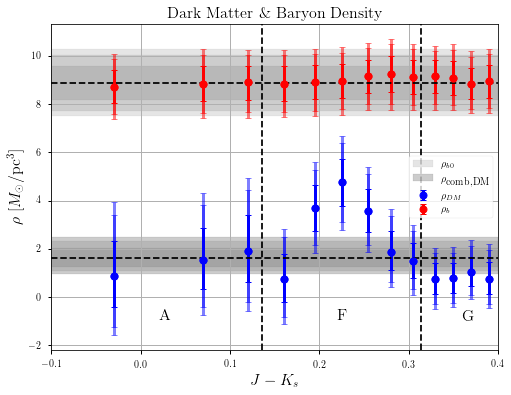

In [30]:
rhoDM_v = np.array(rhoDM_v)
rhoDM_mode = rhoDM_v[:,0]
rhoDM_low68 = rhoDM_v[:,1]
rhoDM_high68 = rhoDM_v[:,2]
rhoDM_err_low68 = rhoDM_mode-rhoDM_low68
rhoDM_err_high68 = rhoDM_high68-rhoDM_mode
rhoDM_low90 = rhoDM_v[:,3]
rhoDM_high90 = rhoDM_v[:,4]
rhoDM_err_low90 = rhoDM_mode-rhoDM_low90
rhoDM_err_high90 = rhoDM_high90-rhoDM_mode
rhoDM_low95 = rhoDM_v[:,5]
rhoDM_high95 = rhoDM_v[:,6]
rhoDM_err_low95 = rhoDM_mode-rhoDM_low95
rhoDM_err_high95 = rhoDM_high95-rhoDM_mode

rhob_v = np.array(rhob_v)
rhob_mode = rhob_v[:,0]
rhob_low68 = rhob_v[:,1]
rhob_high68 = rhob_v[:,2]
rhob_err_low68 = rhob_mode-rhob_low68
rhob_err_high68 = rhob_high68-rhob_mode
rhob_low90 = rhob_v[:,3]
rhob_high90 = rhob_v[:,4]
rhob_err_low90 = rhob_mode-rhob_low90
rhob_err_high90 = rhob_high90-rhob_mode
rhob_low95 = rhob_v[:,5]
rhob_high95 = rhob_v[:,6]
rhob_err_low95 = rhob_mode-rhob_low95
rhob_err_high95 = rhob_high95-rhob_mode
cs = np.linspace(c1.min(), c2.max(), 100)
# plot vertical line for each rho with respect to their c
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(c, rhoDM_mode, yerr=[rhoDM_err_low95, rhoDM_err_high95], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
ax.errorbar(c, rhoDM_mode, yerr=[rhoDM_err_low90, rhoDM_err_high90], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
ax.errorbar(c, rhoDM_mode, yerr=[rhoDM_err_low68, rhoDM_err_high68], fmt='o', color='blue', capsize=3, label=r'$\rho_{DM}$', elinewidth=3, markeredgewidth=1)
ax.errorbar(c, rhob_mode, yerr=[rhob_err_low95, rhob_err_high95], fmt='o', color='red', capsize=3, elinewidth=3, alpha=0.5, markeredgewidth=1)
ax.errorbar(c, rhob_mode, yerr=[rhob_err_low90, rhob_err_high90], fmt='o', color='red', capsize=3, elinewidth=3, alpha=0.5, markeredgewidth=1)
ax.errorbar(c, rhob_mode, yerr=[rhob_err_low68, rhob_err_high68], fmt='o', color='red', capsize=3, elinewidth=3, label=r'$\rho_{b}$', markeredgewidth=1)
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
ax.fill_between(cs, rhob0_low68, rhob0_high68, color='black', alpha=0.1)
ax.fill_between(cs, rhob0_low90, rhob0_high90, color='black', alpha=0.1)
ax.fill_between(cs, rhob0_low95, rhob0_high95, color='black', alpha=0.1, label=r'$\rho_{b0}$')
ax.axhline(y=rhoDM_com_mode, color='black', linestyle='--')
ax.fill_between(cs, rhoDM_com_low68, rhoDM_com_high68, color='black', alpha=0.1)
ax.fill_between(cs, rhoDM_com_low90, rhoDM_com_high90, color='black', alpha=0.1)
ax.fill_between(cs, rhoDM_com_low95, rhoDM_com_high95, color='black', alpha=0.2, label=r'$\rho_{\textup{comb,DM}}$')
ax.axvline(x=b1, color='black', linestyle='--')
ax.axvline(x=b2, color='black', linestyle='--')
ax.text(0.22, -1, r'$\textup{F}$', fontsize=16)
ax.text(0.02, -1, r'$\textup{A}$', fontsize=16)
ax.text(0.36, -1, r'$\textup{G}$', fontsize=16)
ax.set_xlabel(r'$J-K_s$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$M_{\odot}/$pc$^{3}$]', fontsize=16)
ax.set_xlim(c1.min(), c2.max())
# ax.set_ylim(-5.0, 14.0)
ax.set_title("Dark Matter \& Baryon Density", fontsize=16)
ax.grid()
ax.legend(fontsize=10)
fig.savefig('rhoDM-dm.pdf', dpi=200)
plt.show()

In [31]:
for i in range(len(c)):
    print(r"${}\leq c < {}$ & {:.02f} & [{:.02f},{:.02f}] & [{:.02f},{:.02f}] & [{:.02f},{:.02f}] \\".format(c1[i], c2[i], rhoDM_mode[i], rhoDM_low68[i], rhoDM_high68[i], rhoDM_low90[i], rhoDM_high90[i], rhoDM_low95[i], rhoDM_high95[i]))

$-0.1\leq c < 0.04$ & 0.87 & [-0.44,2.34] & [-1.23,3.41] & [-1.60,3.94] \\
$0.04\leq c < 0.1$ & 1.54 & [0.34,2.87] & [-0.40,3.82] & [-0.74,4.30] \\
$0.1\leq c < 0.14$ & 1.92 & [0.61,3.39] & [-0.21,4.43] & [-0.59,4.95] \\
$0.14\leq c < 0.18$ & 0.75 & [-0.23,1.77] & [-0.82,2.49] & [-1.12,2.84] \\
$0.18\leq c < 0.21$ & 3.70 & [2.76,4.66] & [2.15,5.29] & [1.85,5.59] \\
$0.21\leq c < 0.24$ & 4.77 & [3.77,5.75] & [3.12,6.39] & [2.80,6.70] \\
$0.24\leq c < 0.27$ & 3.59 & [2.70,4.49] & [2.15,5.10] & [1.88,5.38] \\
$0.27\leq c < 0.29$ & 1.87 & [1.11,2.74] & [0.63,3.35] & [0.42,3.67] \\
$0.29\leq c < 0.32$ & 1.50 & [0.78,2.25] & [0.33,2.76] & [0.10,2.99] \\
$0.32\leq c < 0.34$ & 0.77 & [0.14,1.41] & [-0.28,1.81] & [-0.49,2.02] \\
$0.34\leq c < 0.36$ & 0.79 & [0.15,1.43] & [-0.25,1.85] & [-0.44,2.06] \\
$0.36\leq c < 0.38$ & 1.04 & [0.44,1.68] & [0.08,2.13] & [-0.09,2.36] \\
$0.38\leq c < 0.4$ & 0.77 & [0.12,1.47] & [-0.28,1.96] & [-0.47,2.21] \\


# BIC AIC

In [42]:
model = 2
data = 0

ndim = 33
nwalkers = 2*ndim+2

In [43]:
data_dir = join(root_dir, 'Data', 'MCMC', 'dm')
data_dir

'/home2/s20321005/Thesis-Project/Data/MCMC/dm'

In [44]:
chain = np.load(join(data_dir, 'data', f'chain-{model}-{data}.npy'))

locs = np.load(join(data_dir, 'data', f'locs-{model}.npy'))
scales = np.load(join(data_dir, 'data', f'scales-{model}.npy'))

zfiles = glob(join(root_dir, 'Data', 'Effective-Volume-v', '*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'Velocity-Distribution-v', 'gaia*.hdf5'))
wfiles.sort()

zfile = zfiles[data]
wfile = wfiles[data]

zdata = vaex.open(zfile)
zmid = zdata['z'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['w'].to_numpy()

In [50]:
probs = np.load(join(data_dir, 'data', f'probs-{model}-{data}.npy'))

likelihood = probs[:, 1]
# filter nan values
likelihood = likelihood[~np.isnan(likelihood)]
max_likelihood = np.max(likelihood)

# calculate BIC
bic = -2 * max_likelihood + ndim * np.log(3*len(zmid)+3*len(wmid))
print(f"BIC: {bic}")
# calculate AIC
aic = -2 * max_likelihood + 2 * ndim
print(f"AIC: {aic}")

BIC: 176.20241663210746
AIC: 87.6920861370082
